# Forecasting - BTC

1) Imports

In [1]:
import warnings
import requests
import json
import pandas as pd
from datetime import datetime, date
warnings.filterwarnings("ignore")
from ts_utils import *

2) Coleta de dados

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
hj = date.today()
futuro_day = date.fromordinal(hj.toordinal()+5) # hoje + 30 dias
print("Data Limite Previsão",futuro_day)

Num GPUs Available:  0
Data Limite Previsão 2021-06-09


In [3]:
# Pegando dados da Api
#dtf = get_data('btc', sample_data=False)
dtf = get_data_df('BTC',40)
# Convertendo timestamp para data
DS = []
for result in dtf['time']:
    DS.append(datetime.fromtimestamp(result))
dtf = pd.DataFrame([DS, dtf['close']]).T
dtf.head()

Buscando dados de :  2021-03-13 13:00:00
Buscando dados de :  2020-12-20 05:00:00
Buscando dados de :  2020-09-27 21:00:00
Buscando dados de :  2020-07-06 13:00:00
Buscando dados de :  2020-04-14 05:00:00
Buscando dados de :  2020-01-21 21:00:00
Buscando dados de :  2019-10-30 13:00:00
Buscando dados de :  2019-08-08 05:00:00
Buscando dados de :  2019-05-16 21:00:00
Buscando dados de :  2019-02-22 13:00:00
Buscando dados de :  2018-12-01 05:00:00
Buscando dados de :  2018-09-08 21:00:00
Buscando dados de :  2018-06-17 13:00:00
Buscando dados de :  2018-03-26 05:00:00
Buscando dados de :  2018-01-01 21:00:00
Buscando dados de :  2017-10-10 13:00:00
Buscando dados de :  2017-07-19 05:00:00
Buscando dados de :  2017-04-26 21:00:00
Buscando dados de :  2017-02-02 13:00:00
Buscando dados de :  2016-11-11 05:00:00
Buscando dados de :  2016-08-19 21:00:00
Buscando dados de :  2016-05-28 13:00:00
Buscando dados de :  2016-03-06 05:00:00
Buscando dados de :  2015-12-13 21:00:00
Buscando dados d

0      1
0 2012-04-19 13:00:00  5.138
1 2012-04-19 14:00:00  5.138
2 2012-04-19 15:00:00  5.138
3 2012-04-19 16:00:00  5.138
4 2012-04-19 17:00:00  5.138

In [4]:
dtf.columns = ['date', 'close']
ts = dtf.groupby("date")["close"].sum().rename("sales")
ts.tail()

date
2021-06-04 17:00:00    37048.61
2021-06-04 18:00:00    37224.84
2021-06-04 19:00:00    37122.15
2021-06-04 20:00:00    36861.50
2021-06-04 21:00:00    37584.39
Name: sales, dtype: float64

3) Analise de séries temporais

Numero de observações:  80001
Valor maximo: $ 119745.22
Valor minimo: $ 5.138


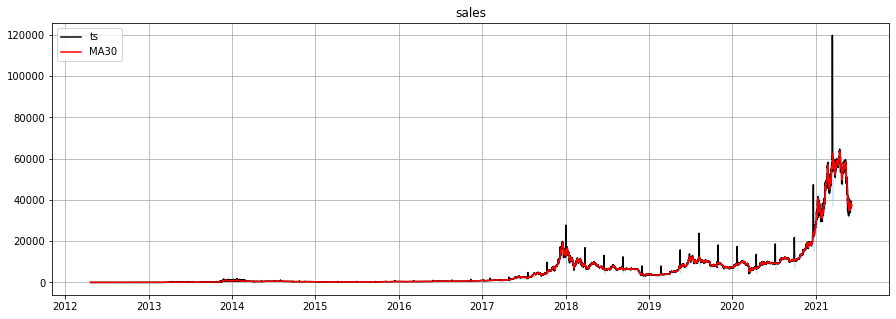

In [5]:
print("Numero de observações: ",len(ts))
print("Valor maximo: $",max(ts))
print("Valor minimo: $",min(ts))
w = 30
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))

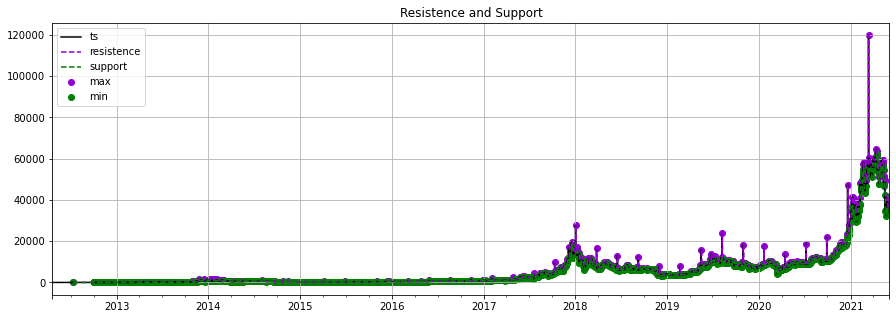

In [6]:
# Analise de maximos e minimos
res_sup = resistence_support(ts, window=30, trend=False, plot=True, figsize=(15,5))

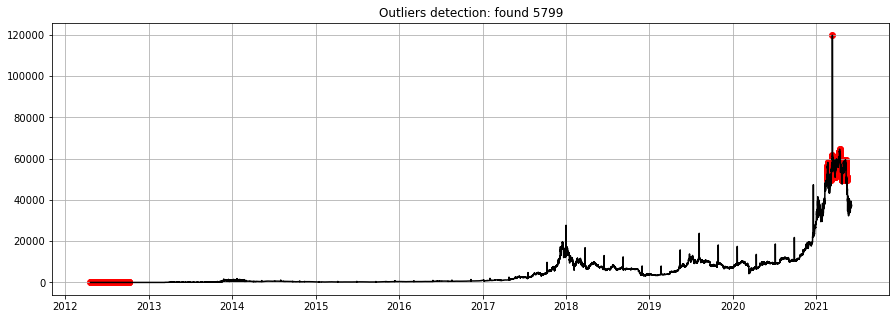

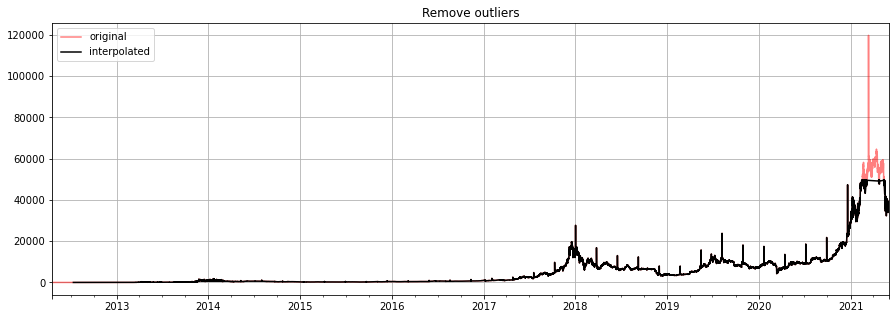

In [7]:
#Removendo outliers
dtf_outliers = find_outliers(ts, perc=0.05, figsize=(15,5))
ts_clean = remove_outliers(ts, outliers_idx=dtf_outliers[dtf_outliers["outlier"]==1].index, figsize=(15,5))

4) Processamento

--- splitting at index:  79200 | 2021-05-02 13:00:00 | test size: 0.01  ---


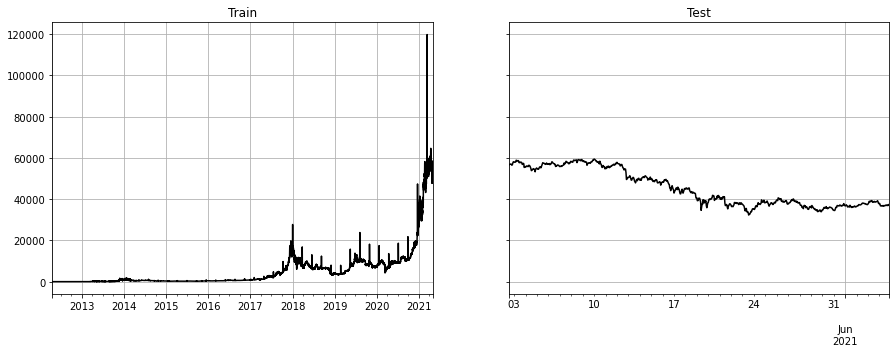

train: 79200 obs  |  test: 801 obs


In [8]:
ts_train, ts_test = split_train_test(ts, exog=None, test=0.01, plot=True, figsize=(15,5))
print("train:", len(ts_train), "obs  |  test:", len(ts_test), "obs")

5) Regressão Linear

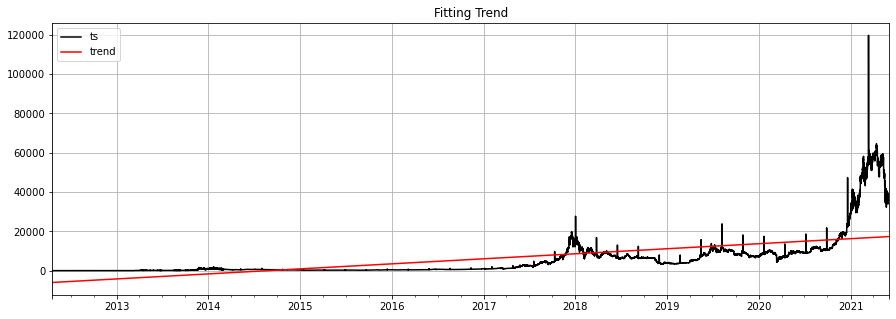

In [32]:
trend, line = fit_trend(ts, degree=1, plot=True, figsize=(15,5))

6) Regressão Polinomial

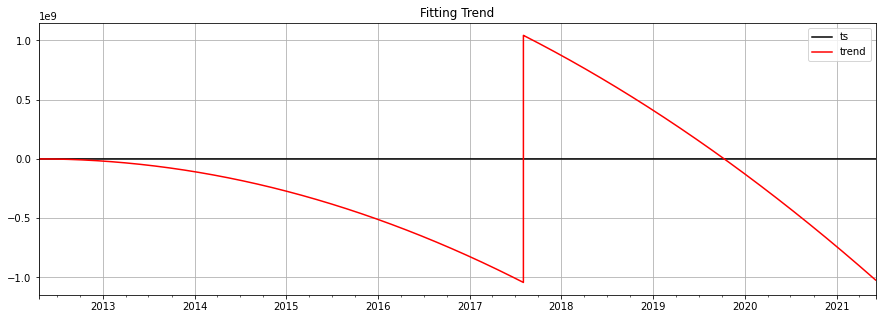

In [33]:
trend, line = fit_trend(ts, degree=2, plot=True, figsize=(15,5))

7) Arima

In [ ]:
# Tuning
s=7
res = tune_expsmooth_model(ts_train, s=s, val_size=0.2, scoring=metrics.mean_absolute_error, top=4, figsize=(15,5))
res.head()

In [ ]:
# Forecast unknown
#model = smt.ExponentialSmoothing(ts, trend="additive", damped=False, 
#                                 seasonal="multiplicative", seasonal_periods=s).fit(0.64)

#future = forecast_autoregressive(ts, model, end=futuro_day, conf=0.30, zoom=30, figsize=(15,5))

In [ ]:
# *pode demorar
res = tune_arima_model(ts_train, s=s, val_size=0.2, max_order=(1,1,1), seasonal_order=(1,0,1),
                        scoring=metrics.mean_absolute_error, top=3, figsize=(15,5))
res.head()

In [ ]:
# *pode demorar
find_best_sarimax(ts_train, seasonal=True, stationary=False, s=s, exog=None,
                  max_p=10, max_d=3, max_q=10, 
                  max_P=1, max_D=1, max_Q=1)

In [ ]:
# Traino/Test
dtf, model = fit_sarimax(ts_train, ts_test, order=(1,1,1), seasonal_order=(1,0,1), s=s, conf=0.95, figsize=(15,10))

In [ ]:
# previsão
model = smt.SARIMAX(ts, order=(1,1,1), seasonal_order=(1,0,1,s), exog=None).fit()

future = forecast_autoregressive(ts, model, end=futuro_day, conf=0.95, zoom=30, figsize=(15,5))

8) LSTM

In [ ]:
s = 365
n_features = 1

In [ ]:
model = models.Sequential()
model.add( layers.LSTM(input_shape=(s,n_features), units=50, activation='relu', return_sequences=True) )
model.add( layers.Dropout(0.2) )
model.add( layers.LSTM(units=50, activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

In [ ]:
dtf, model = fit_lstm(ts_train, ts_test, model, exog=None, s=s, epochs=100, conf=0.20, figsize=(15,10))

In [ ]:
future = forecast_lstm(ts, model, conf=0.20, end=futuro_day, freq="D", zoom=30, figsize=(15,5))

9) Prophet

In [ ]:
# Crie dataframe com colunas 'ds' (datas), 'y' (valores), 'cap' (capacidade de crescimento = "logística")
dtf_train = ts_train.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf_test = ts_test.reset_index().rename(columns={"date":"ds", "sales":"y"})

dtf_train.tail()

In [ ]:
# Crie feriados dataFrame com as colunas 'ds' (datas) e 'feriado' (string ex 'xmas')
dtf_holidays = None

In [ ]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

In [ ]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D", figsize=(15,10))

In [ ]:
dtf = ts.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf.tail()

In [ ]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

In [ ]:
future = forecast_prophet(dtf, model, end=futuro_day, freq="D", zoom=30, figsize=(15,5))